## 1. Setup

### 1.1 Import libraries

In [1]:
from qiskit import QuantumCircuit
from qiskit import transpile
from qiskit_aer import AerSimulator
import random

### 1.2 Quantum Circuit Helper methods 

In [2]:
def run_circuit(circuit, shots=1):
    simulator = AerSimulator()
    circ = transpile(qc, simulator)

    job = simulator.run(circ, shots=shots)
    return job.result(), circ

In [3]:
qc = QuantumCircuit(2, 2)

qc.x(1)

qc.measure(0, 0)
qc.measure(1, 1)

result, circ = run_circuit(qc, shots=1000)
print(result.get_counts(circ))

{'10': 1000}


## 2. Test Single Qubit

### 2.1 Create Encoded Qubits

In [4]:
def init_qubit(qc, idx, state):
    if state == 0:
        pass
    elif state == 1:
        qc.x(idx)
    elif state == 2:
        qc.h(idx)
    elif state == 3:
        qc.x(idx)
        qc.h(idx)
    return qc

def measure_in_basis(qc, idx, basis):
    if basis == 0:
        pass
    elif basis == 1:
        qc.h(idx)
    return qc

# |0>, |+> => 0
# |1>, |-> => 1
def state_to_bit(state):
    if state % 2 == 0:
        return 0
    else:
        return 1

def validate(state, guess, result):
    if guess == 0 and state in [0, 1]:
        guess_correct = True
    elif guess == 1 and state in [2, 3]:
        guess_correct = True
    else:
        guess_correct = False
        
    result_correct = state_to_bit(state) == result

    return guess_correct, result_correct


### 2.2 Run 1000 times

After 1000 samples, the number of correctly measured qubits should be ~75%. There is a 50% chance of guessing the correct basis.

In [5]:
n = 1000
correct_guesses = 0
correct_results = 0


for i in range(n):
    state = random.randint(0, 3)
    qc = QuantumCircuit(1,1)
    qc = init_qubit(qc, 0, state)

    # guess state to measure
    # 0: standard, 1: horizontal
    guess = random.randint(0, 1)
    qc = measure_in_basis(qc, 0, guess)

    qc.measure_all(add_bits=False)

    result, circ = run_circuit(qc)
    counts = result.get_counts(circ)
    guess_correct, result_correct = validate(state, guess, int(list(counts.keys())[0]))
    
    if guess_correct:
        correct_guesses += 1
    if result_correct:
        correct_results += 1

print(f"Correct guesses: {correct_guesses} ({correct_guesses/n*100}%)")
print(f"Correct results: {correct_results} ({correct_results/n*100}%)")


Correct guesses: 483 (48.3%)
Correct results: 748 (74.8%)


## 3. Scale Number of Qubits

### 3.1 Helper methods


In [6]:
def generate_state_set(n):
    states = []
    for i in range(n):
        state = random.randint(0, 3)
        states.append(state)
    return states

def generate_circuit_from_state_set(states):
    n = len(states)
    qc = QuantumCircuit(n, n)
    for i in range(n):
        qc = init_qubit(qc, i, states[i])

    return qc

def generate_guess_set(n):
    guesses = []
    for i in range(n):
        guess = random.randint(0, 1)
        guesses.append(guess)
    return guesses

def measure_circuit(qc, guesses):
    n = len(guesses)
    for i in range(n):
        qc = measure_in_basis(qc, i, guesses[i])
    return qc


def validate_sets(states, guesses, results):
    correct_results = False
    correct_bits = 0
    for i in range(len(states)):
        state = states[i]
        state_bit = state_to_bit(state)
        result_bit = results[i]
        if state_bit == result_bit:
            correct_bits += 1

    if correct_bits == len(states):
        correct_results = True

    # confirm that the guess was correct
    correct_guesses = 0
    for i in range(len(states)):
        state = states[i]
        guess = guesses[i]
        if guess == 0 and state in [0, 1]:
            correct_guesses += 1
        elif guess == 1 and state in [2, 3]:
            correct_guesses += 1
    # number of correct guesses, correct result(true/false), number of correct bits
    return correct_guesses, correct_results, correct_bits

    

def highest_probability_result(counts):
    # choose the key with the highest value
    return max(counts, key=counts.get)
    



### 3.2 Test up to 20 Qubits

In [7]:
NUM_QUBITS = 20

measurement_results = []
# run the experiment for 1 to 20 qubits
for i in range(NUM_QUBITS):
    total_correct_guesses = 0
    total_correct_results = 0
    total_correct_bits = 0
    # run the experiment n times
    # with unique sets of qubits and guesses
    for j in range(n):
        # generate a set of n encoded qubits
        state = generate_state_set(i + 1)
        qc = generate_circuit_from_state_set(state)

        # generate a set of n basis guesses
        guess = generate_guess_set(i + 1)
        # measure each qubit in the basis
        qc = measure_circuit(qc, guess)

        # run the circuit
        qc.measure_all(add_bits=False)
        result, circ = run_circuit(qc)
        counts = result.get_counts(circ)
        results_str = highest_probability_result(counts)[::-1]
        results = [int(c) for c in results_str]
        
        correct_guesses, correct_results, correct_bits = validate_sets(state, guess, results)
        total_correct_guesses += correct_guesses
        total_correct_bits += correct_bits
        if correct_results:
            total_correct_results += 1
    print(f"{i + 1} Qubits")
    print(f"Correct guesses: {total_correct_guesses} ({total_correct_guesses/((i + 1) * n)*100}%)")
    print(f"Correct bits: {total_correct_bits} ({total_correct_bits/((i + 1) * n)*100}%)")
    print(f"Correct results: {total_correct_results} ({total_correct_results/n*100}%)")
    measurement_results.append({
        "qubits": i + 1,
        "correct_guesses": total_correct_guesses,

        "correct_bits": total_correct_bits,
        "correct_results": total_correct_results,
        "correct_results_percent": total_correct_results/n*100
    })

1 Qubits
Correct guesses: 459 (45.9%)
Correct bits: 729 (72.89999999999999%)
Correct results: 729 (72.89999999999999%)
2 Qubits
Correct guesses: 1013 (50.64999999999999%)
Correct bits: 1548 (77.4%)
Correct results: 604 (60.4%)
3 Qubits
Correct guesses: 1515 (50.5%)
Correct bits: 2245 (74.83333333333333%)
Correct results: 411 (41.099999999999994%)
4 Qubits
Correct guesses: 2030 (50.74999999999999%)
Correct bits: 2996 (74.9%)
Correct results: 315 (31.5%)
5 Qubits
Correct guesses: 2494 (49.88%)
Correct bits: 3739 (74.78%)
Correct results: 252 (25.2%)
6 Qubits
Correct guesses: 2927 (48.78333333333333%)
Correct bits: 4478 (74.63333333333333%)
Correct results: 179 (17.9%)
7 Qubits
Correct guesses: 3588 (51.25714285714286%)
Correct bits: 5296 (75.65714285714286%)
Correct results: 133 (13.3%)
8 Qubits
Correct guesses: 3944 (49.3%)
Correct bits: 6002 (75.02499999999999%)
Correct results: 110 (11.0%)
9 Qubits
Correct guesses: 4514 (50.15555555555555%)
Correct bits: 6723 (74.7%)
Correct results: 

### 3.3 Plot Results

In [8]:
import matplotlib.pyplot as plt

correct_results = [r["correct_results_percent"] for r in measurement_results]
correct_guesses = []
for i in range(NUM_QUBITS):
    correct_guesses.append(measurement_results[i]["correct_guesses"] / ((i + 1) * n) * 100)
correct_bits = []
for i in range(NUM_QUBITS):
    correct_bits.append(measurement_results[i]["correct_bits"] / ((i + 1) * n) * 100)
    
qubits = [r["qubits"] for r in measurement_results]

### 3.3.1 Plot Actual Measurement vs Theoretical Measurement

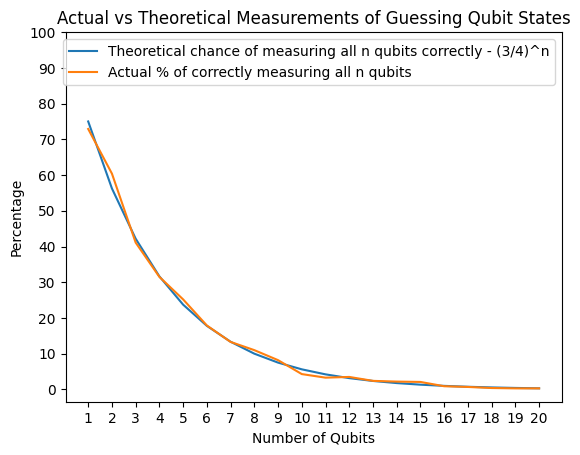

In [18]:
plt.plot(qubits, [(3/4)**n * 100 for n in qubits], label="Theoretical chance of measuring all n qubits correctly - (3/4)^n")
plt.plot(qubits, correct_results, label="Actual % of correctly measuring all n qubits")

plt.legend()

plt.xlabel("Number of Qubits")
plt.ylabel("Percentage")
plt.title("Actual vs Theoretical Measurements of Guessing Qubit States")

plt.xticks(range(1, NUM_QUBITS + 1))
plt.yticks(range(0, 101, 10))
plt.show()



Wiesner's paper states that there's a 75% chance of measuring the correct result from a single encoded qubit. This scales expontentially as (3/4)^n where n is the number of qubits in the system. (blue curve)

In this graph, we can see that our actual measurements (orange) follows the curve, but not too tightly.

### 3.3.2 Plot Guessing individual bit results

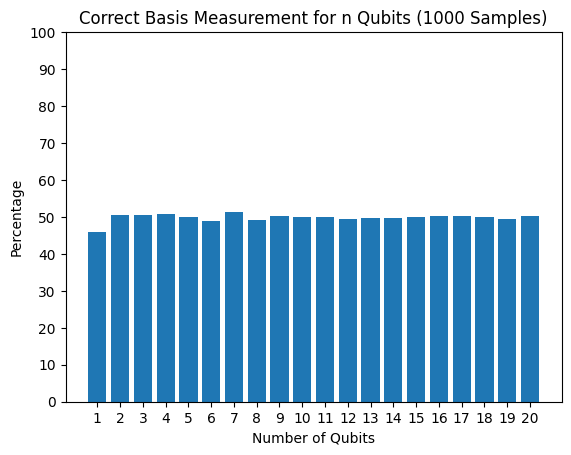

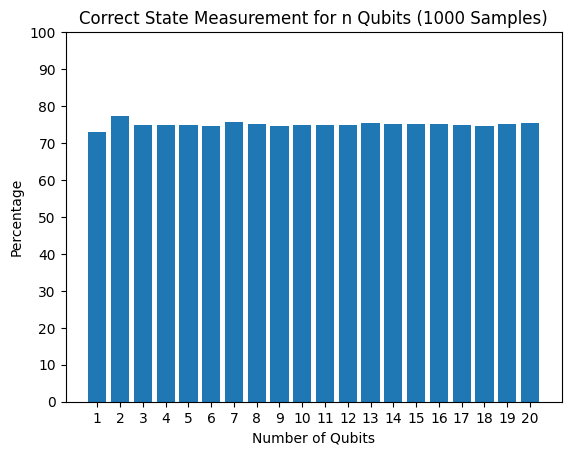

In [23]:
plt.bar(qubits, correct_guesses)
plt.xlabel("Number of Qubits")
plt.ylabel("Percentage")
plt.title(f"Correct Basis Measurement for n Qubits ({n} Samples)")
plt.xticks(range(1, 21))
plt.yticks(range(0, 101, 10))
plt.show()

plt.bar(qubits, correct_bits)
plt.xlabel("Number of Qubits")
plt.ylabel("Percentage")
plt.title(f"Correct State Measurement for n Qubits ({n} Samples)")
plt.xticks(range(1, 21))
plt.yticks(range(0, 101, 10))
plt.show()

There is only two basis (standard and diagonal), therefore it's there's only a 50% chance of guessing the correct basis. (blue curve)

For a single qubit system, the chance of yielding the correct bit at random is 75%. However, this seems to converge towards 50% as the number of qubits increase. (orange curve)

## 4 Transmitting a Hashed message 

### 4.1 Import libraries

In [11]:
import hashlib

### 4.2 Create a SHA256 Hash

In [12]:
secret_message = "https://youtu.be/dQw4w9WgXcQ"

m = hashlib.sha256()
m.update(secret_message.encode("utf-8"))
hashed_message = m.hexdigest()

### 4.3 Convert Hash into Binary Data

In [13]:
# convert each hexadecimal character to binary bytes
binary_messages = []
for c in hashed_message:
    binary_messages.append(format(int(c, 16), "04b"))

print(hashed_message)
print(binary_messages)

61e610a9d7fd37bc9df752aa7dd374f0852a4ab0d59bd3cad47afa5cb604fd01
['0110', '0001', '1110', '0110', '0001', '0000', '1010', '1001', '1101', '0111', '1111', '1101', '0011', '0111', '1011', '1100', '1001', '1101', '1111', '0111', '0101', '0010', '1010', '1010', '0111', '1101', '1101', '0011', '0111', '0100', '1111', '0000', '1000', '0101', '0010', '1010', '0100', '1010', '1011', '0000', '1101', '0101', '1001', '1011', '1101', '0011', '1100', '1010', '1101', '0100', '0111', '1010', '1111', '1010', '0101', '1100', '1011', '0110', '0000', '0100', '1111', '1101', '0000', '0001']


### 4.4 Encode into Qubits

In [14]:
circuits = []
states = []
for binary in binary_messages:
    qc = QuantumCircuit(4, 4)
    state_cache = []
    for i in range(4):
        basis = random.randint(0, 1)
        bit = int(binary[i])
        state = 2 * basis + bit
        state_cache.append(state)
        qc = init_qubit(qc, i, state)
    circuits.append(qc)
    states.append(state_cache)

print(states)

[[0, 1, 3, 2], [2, 2, 2, 1], [1, 3, 1, 2], [0, 3, 1, 2], [2, 2, 2, 3], [0, 2, 0, 0], [3, 2, 3, 0], [3, 0, 2, 1], [3, 1, 2, 1], [0, 3, 1, 1], [3, 3, 3, 3], [3, 3, 0, 3], [0, 0, 1, 3], [0, 1, 3, 1], [1, 0, 3, 1], [3, 1, 0, 2], [1, 2, 2, 3], [1, 3, 0, 3], [1, 1, 1, 1], [2, 1, 1, 1], [0, 1, 2, 3], [0, 2, 1, 0], [3, 0, 1, 0], [1, 0, 3, 2], [2, 3, 3, 3], [1, 1, 0, 3], [1, 3, 2, 3], [2, 2, 3, 1], [2, 3, 3, 1], [2, 1, 2, 0], [3, 3, 3, 1], [2, 0, 2, 2], [3, 2, 0, 2], [2, 1, 2, 3], [2, 0, 1, 2], [1, 2, 1, 2], [2, 1, 0, 2], [1, 0, 3, 2], [3, 2, 3, 1], [0, 0, 2, 0], [3, 1, 2, 1], [0, 1, 2, 3], [1, 2, 2, 3], [1, 0, 1, 3], [1, 1, 0, 3], [2, 2, 3, 3], [1, 1, 0, 2], [1, 2, 1, 2], [1, 1, 2, 3], [0, 3, 0, 0], [0, 3, 3, 3], [3, 2, 3, 2], [1, 3, 3, 3], [3, 0, 1, 0], [2, 1, 0, 3], [3, 3, 0, 2], [3, 2, 3, 3], [0, 1, 3, 2], [0, 0, 2, 2], [0, 3, 0, 2], [1, 3, 3, 3], [3, 3, 0, 1], [0, 0, 2, 0], [2, 0, 2, 3]]


### 4.5 Measure Received Qubits by selecting Random Basis

In [15]:
constructed_hash = ""

for i in range(len(circuits)):
    qc = circuits[i]
    chosen_basis = [random.randint(0, 1) for i in range(4)]
    qc = measure_circuit(qc, chosen_basis)    
    qc.measure_all(add_bits=False)
    
    result, circ = run_circuit(qc)
    counts = result.get_counts(circ)
    results_str = highest_probability_result(counts)[::-1]
    # convert the binary string to a hexadecimal character
    constructed_hash += hex(int(results_str, 2))[2:]

print(constructed_hash)


61b495e9e75c6ff83de747ba393375f0c3ebdb3c57dbb3ead468a2bc90057809


### 4.6 Compare Reconstructed Hash with Original Hash

In [16]:
def validate_hashes(hashed_message, constructed_hash):
    matches = 0
    for i in range(len(hashed_message)):
        if hashed_message[i] == constructed_hash[i]:
            matches += 1
    return matches

matches = validate_hashes(hashed_message, constructed_hash)
print(f"Matches: {matches} ({matches/64*100}%)")


Matches: 19 (29.6875%)
